In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Code von letzter Woche zum Importieren und Transformieren der Titanic Datensatzes

In [2]:
from sklearn.impute import SimpleImputer

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)


columns_to_drop = ['home.dest', 'body', 'boat', 'embarked', 'cabin', 'name', 'ticket']
df_droped = df.drop(columns= columns_to_drop)


im = SimpleImputer(strategy='median')  
df_droped[['fare', 'age']] = im.fit_transform(df_droped[['fare', 'age']])

cleaned_data = pd.get_dummies(df_droped, drop_first=True)

X = cleaned_data[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']]
y = cleaned_data['survived']

# Split Train Test

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Baseline mit Dummy Classifier

In [4]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.6157760814249363

In [5]:
y_pred = dummy_clf.predict(X_test)

In [6]:
from sklearn import metrics
auc_score = metrics.roc_auc_score(y_test, y_pred)

print(f"Test AUC score: {auc_score}")

Test AUC score: 0.5


# Entscheidungsbaum-Verfahren mit Grid-Search

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [8]:
params = {
    'max_depth' : [1, 2, 3, 4, 5, 6, None],
    'criterion': ['gini', 'entropy']
}



In [9]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(estimator = clf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)

In [10]:
grid_clf.fit(X_train, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.9s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, None]},
             scoring='accuracy', verbose=1)

In [11]:
# Identify optimal hyperparameter values
best_criterion      = grid_clf.best_params_['criterion']
best_max_depth = grid_clf.best_params_['max_depth']  

print(f"Best cross-validation score: {grid_clf.best_score_:.3f}")
print(f"The best performing criterion value is: {best_criterion}")
print(f"The best performing max_depth value is: {best_max_depth}")

Best cross-validation score: 0.810
The best performing criterion value is: gini
The best performing max_depth value is: 3


In [12]:
grid_clf.score(X_test, y_test)

0.806615776081425

In [13]:
print(grid_clf.cv_results_)

{'mean_fit_time': array([0.00640075, 0.00590358, 0.00594623, 0.00573468, 0.00621903,
       0.00649185, 0.00791521, 0.00571826, 0.00614088, 0.00636115,
       0.00675869, 0.00687263, 0.00708392, 0.0083041 ]), 'std_fit_time': array([0.00107367, 0.00030354, 0.00053199, 0.00044175, 0.00054942,
       0.00047253, 0.00144359, 0.00049841, 0.00018225, 0.00016705,
       0.00021619, 0.00032123, 0.00037441, 0.00083974]), 'mean_score_time': array([0.00341659, 0.00329571, 0.00319829, 0.00299585, 0.00322883,
       0.00380676, 0.0034426 , 0.00344396, 0.00342987, 0.00413857,
       0.00345905, 0.00335765, 0.00334179, 0.00300741]), 'std_score_time': array([2.50507385e-04, 1.18696531e-04, 4.78482961e-04, 3.97552329e-04,
       6.93931640e-05, 1.76227340e-03, 1.81474445e-04, 1.60874215e-04,
       1.14697995e-04, 2.05597636e-03, 2.77145986e-04, 1.49327059e-04,
       1.42791801e-04, 3.60611896e-04]), 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
        

In [14]:
import pandas as pd

grid_search_results = pd.pivot_table(pd.DataFrame(grid_clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_criterion')

grid_search_results

param_criterion,entropy,gini
param_max_depth,,
1,0.785965,0.785965
2,0.788127,0.791388
3,0.800203,0.810081
4,0.801326,0.799116
5,0.783803,0.792570
6,0.798017,0.797957


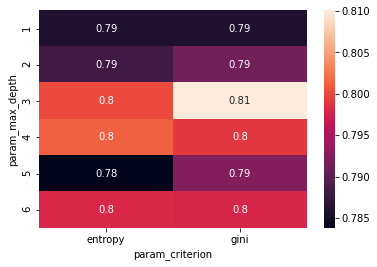

In [15]:
import seaborn as sns       
ax = sns.heatmap(grid_search_results, annot=True)

In [16]:
clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
auc_score = metrics.roc_auc_score(y_test, y_pred)

print(f"Test AUC score: {auc_score}")


Test AUC score: 0.7807180778282525


In [18]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       242
           1       0.80      0.67      0.73       151

    accuracy                           0.81       393
   macro avg       0.80      0.78      0.79       393
weighted avg       0.81      0.81      0.80       393



[Text(558.0, 951.3000000000001, 'sex_male <= 0.5\ngini = 0.472\nsamples = 916\nvalue = [567, 349]\nclass = dead'),
 Text(279.0, 679.5, 'pclass <= 2.5\ngini = 0.398\nsamples = 339\nvalue = [93, 246]\nclass = survived'),
 Text(139.5, 407.70000000000005, 'age <= 56.5\ngini = 0.122\nsamples = 184\nvalue = [12, 172]\nclass = survived'),
 Text(69.75, 135.89999999999998, 'gini = 0.099\nsamples = 172\nvalue = [9, 163]\nclass = survived'),
 Text(209.25, 135.89999999999998, 'gini = 0.375\nsamples = 12\nvalue = [3, 9]\nclass = survived'),
 Text(418.5, 407.70000000000005, 'fare <= 24.808\ngini = 0.499\nsamples = 155\nvalue = [81, 74]\nclass = dead'),
 Text(348.75, 135.89999999999998, 'gini = 0.498\nsamples = 136\nvalue = [64, 72]\nclass = survived'),
 Text(488.25, 135.89999999999998, 'gini = 0.188\nsamples = 19\nvalue = [17, 2]\nclass = dead'),
 Text(837.0, 679.5, 'age <= 11.25\ngini = 0.293\nsamples = 577\nvalue = [474, 103]\nclass = dead'),
 Text(697.5, 407.70000000000005, 'sibsp <= 2.0\ngini = 

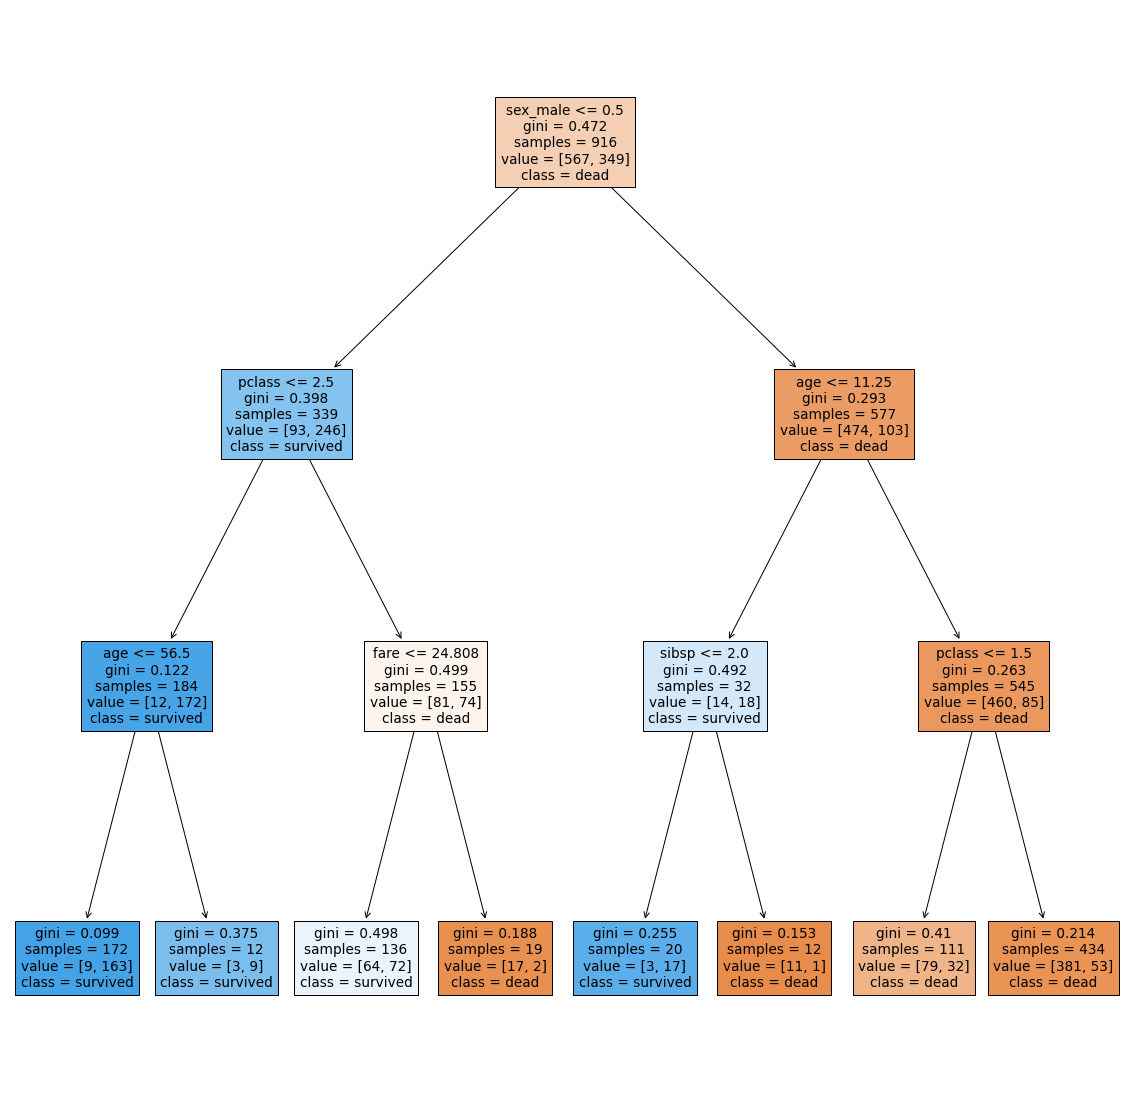

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=X_train.columns, class_names=['dead', 'survived'], filled = True)

# Xtreem Boosting Classifier

In [20]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       242
           1       0.79      0.64      0.71       151

    accuracy                           0.80       393
   macro avg       0.80      0.77      0.78       393
weighted avg       0.80      0.80      0.79       393



# Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       242
           1       0.78      0.67      0.72       151

    accuracy                           0.80       393
   macro avg       0.79      0.77      0.78       393
weighted avg       0.80      0.80      0.80       393

